<h5> Building an RNN from scratch using PyTorch to predict job title from job descriptions using the Glassdoor Data Science jobs dataset available in Kaggle</h5>

<p>If you're thinking why an RNN in the age of Transformers, it is because I'm curious to get a better understanding of how an RNN works under the hood.
So let's get started!
</p>


## <h1> Data science jobs analysis </h1>

<p>
Exploring the Glassdoor Data Science jobs dataset from Kaggle. The data is collected from the Glassdoor site for data science jobs in the US.
</p> 

<p>
<b>Link to the dataset : </b><a href = "https://www.kaggle.com/datasets/rkb0023/glassdoor-data-science-jobs">
https://www.kaggle.com/datasets/rkb0023/glassdoor-data-science-jobs
</a>
</p>

In [1]:
#Importing main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
%matplotlib inline
plt.rcParams["figure.figsize"] = (30,30)

# Dataset description


Dataset columns and metadata

*   Job Title - Describes the position and nature of work 
*   Salary Estimate - Range of salary in US dollars
*   Job Description - Brief description of the work responsibilities, expected candidate qualifications, technology stack to be familiar with and the like
*   Rating - The company rating on Glassdoor
*   Company Name
*   Location - Address of the office for the job posting
*   Headquarters - The company headquarters
*   Size - Number of employees of the company
*   Founded - Year in which company was established
*   Type of ownership - Defines if company is public or private
*   Industry - which field does the company offer services in
*   Sector - type of service
*   Revenue
*   Competitors

For predicting the job title, we will consider the corresponding job description so we will work with only textual data

We will use opendatasets Python library to download the data

In [2]:
!pip install opendatasets --upgrade
!pip install torcheval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 7.9 MB/s eta 0:00:00


In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/rkb0023/glassdoor-data-science-jobs'
od.download('https://www.kaggle.com/datasets/rkb0023/glassdoor-data-science-jobs')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: suchandra1datta
Your Kaggle Key: ··········


100%|██████████| 1.19M/1.19M [00:00<00:00, 69.5MB/s]

# Problem statement 

<p>Given a job description, predict the corresponding job title <br/>
This is a sequence classification problem<br/>
We will solve this using a recurrent neural network model (RNN) </p>

# Data cleaning and exploratory data analysis

The following code snippet contains various utility fucntions for visualizing data

In [4]:
def entity_freq(df, col_name):
  '''
  Helper function to return a new df with value counts of a df based on specified col_name
  '''
  new_df = df[col_name].value_counts().reset_index()
  return new_df

Let's load the dataset and see what the first few rows look like

In [5]:
df = pd.read_csv("/content/glassdoor-data-science-jobs/glassdoor_jobs.csv")
print(df.info())
print("Missing values/NaNs per column: ")
print(df.isnull().sum())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job Title          1000 non-null   object 
 1   Salary Estimate    1000 non-null   object 
 2   Job Description    1000 non-null   object 
 3   Rating             1000 non-null   float64
 4   Company Name       1000 non-null   object 
 5   Location           1000 non-null   object 
 6   Headquarters       1000 non-null   object 
 7   Size               1000 non-null   object 
 8   Founded            1000 non-null   int64  
 9   Type of ownership  1000 non-null   object 
 10  Industry           1000 non-null   object 
 11  Sector             1000 non-null   object 
 12  Revenue            1000 non-null   object 
 13  Competitors        1000 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage: 109.5+ KB
None
Missing values/NaNs per column: 
Job Title            0


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors
0,Data Scientist,$77K-$92K (Glassdoor Est.),Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee"
1,Data Scientist,$77K-$92K (Glassdoor Est.),"Secure our Nation, Ignite your Future\n\nSumma...",4.1,ManTech\n4.1,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,1968,Company - Public,Research & Development,Business Services,₹100 to ₹500 billion (INR),-1
2,Data Scientist,$77K-$92K (Glassdoor Est.),"By clicking the Apply button, I understand tha...",3.7,Takeda\n3.7,"Cambridge, MA","OSAKA, Japan",10000+ employees,1781,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,₹500+ billion (INR),"Novartis, Baxter, Pfizer"
3,Data Scientist,$77K-$92K (Glassdoor Est.),Join Our Growing Team\nA career with A Place f...,3.0,A Place for Mom\n3.0,"Overland Park, KS","New York, NY",501 to 1000 employees,2000,Company - Private,Healthcare Services & Hospitals,Healthcare,Unknown / Non-Applicable,"Enlivant, Sunrise Senior Living, Brookdale Sen..."
4,Data Scientist,$77K-$92K (Glassdoor Est.),We are looking for Data Scientists who are int...,3.7,GovTech\n3.7,"San Francisco, CA","Singapore, Singapore",1001 to 5000 employees,2016,Government,Government Agencies,Government,Unknown / Non-Applicable,-1


<h1> What is the class distribution like ? </h1>
We do not have any missing values to handle.
<br/>
Let's see the count for the different job titles via a bar chart. <br/>We ignore those job titles which has lesser than or equal to 5 records ( means we have only <=5 samples for it ) in the dataframe

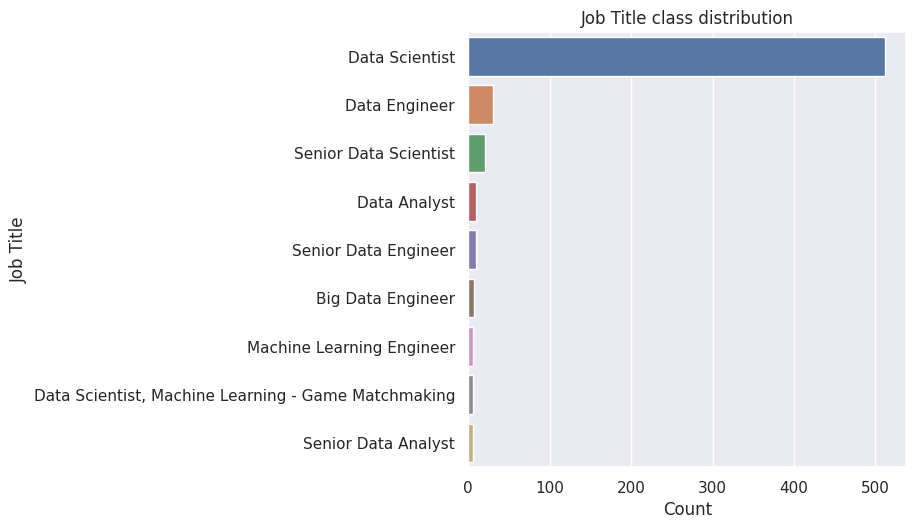

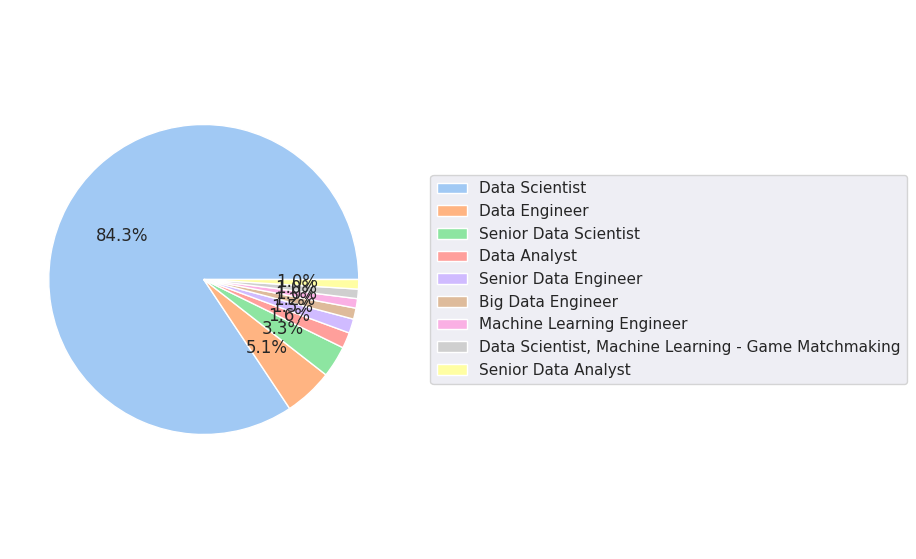

In [6]:
def plot_class_dist(df, col_name='Job Title', min_support=5):
  '''
  Plot bar graph of classes who has more than 5 samples in df.
  Plot a pie chart for the same, showing the % proportion of each class
  '''
  new_df = entity_freq(df, col_name)
  new_df = new_df.rename(columns={"index":col_name, col_name:"freq"})
  new_df = new_df[new_df["freq"]>min_support]
  labels = new_df[col_name].values
  count = new_df["freq"].values

  #Class distribution
  sns.set(rc={'figure.figsize':(5.65,5.65)})
  sns.barplot(x=count,y=labels, orient='h')\
  .set(title='Job Title class distribution', xlabel="Count", ylabel="Job Title")

  #Class distribution in %
  colors = sns.color_palette('pastel')[0:len(labels)]
  fig, ax = plt.subplots(1,2,figsize=(11,7))
  p = ax[0].pie(count, colors = colors, autopct='%.1f%%')
  ax[1].legend(p[0], labels, loc="center")
  ax[1].axis("off")
  plt.show()

plot_class_dist(df)

We can see the dataset is highly skewed, 84% of it is job descriptions for data scientists, followed by data engineer, senior data engineer and the rest. Let's see if we can fix this.

<br/>
<p>From the graph, we select 4 main job titles</p?
<ul>
    <li>Data Scientist</li>
    <li>Data Engineer</li>
    <li>Machine Learning Engineer</li>
    <li>Data Analyst</li>
</ul>
<p>
All other titles we set to data consultant

<br/>
In the dataset we modify the labels, reducing the variations to the above 4 main types. 
Example - Data Scientist Level 1, Data Scientist in Artificial Intelligence - Early Career will all become Data Scientist</p>



In [7]:
classes = ['data scientist', 'data engineer', 'machine learning engineer', 'data analyst']
def adj_classes(title):
  '''
  Normalize job title by converting it to one of ['data scientist', 'data engineer', 'machine learning engineer', 'data analyst']
  '''
  for c in classes:
    if c in title.lower():
      return c
  return 'data consultant'

def clean_text(text):
  text = text.lower()
  new_text = "".join([e for e in text if ord(e) in range(97,123) or ord(e)==32])
  return new_text

df["normalized_adj_classes"] = df.apply(lambda x: adj_classes(x["Job Title"]), \
                                        axis=1)

df["sequence_len"] = df["Job Description"].apply(lambda x:len(x))
df = df[df["sequence_len"]>=100]

In [8]:
df["normalized_adj_classes"].value_counts()

data scientist               627
data consultant              213
data engineer                 85
data analyst                  60
machine learning engineer     15
Name: normalized_adj_classes, dtype: int64

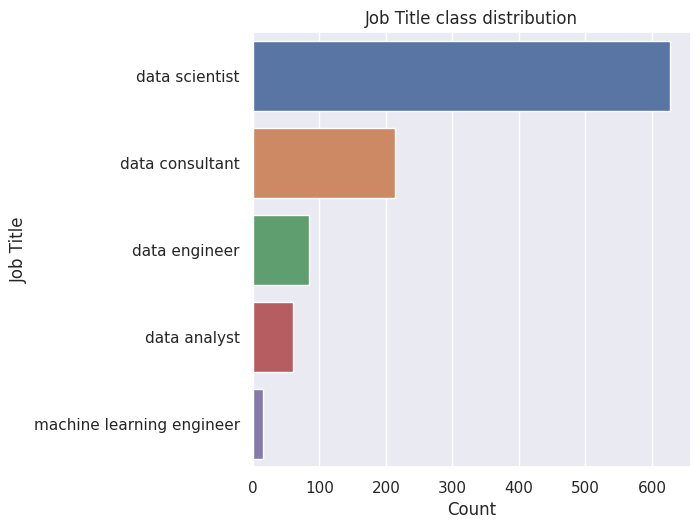

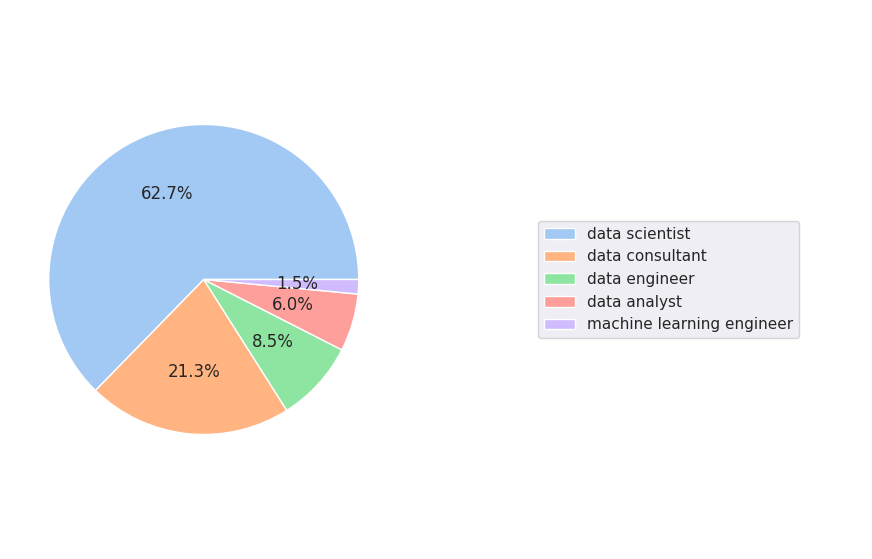

In [9]:
plot_class_dist(df, 'normalized_adj_classes')

The class-wise support looks a bit better now.

<h1> How does the salary range compare across the different classes ? </h1>

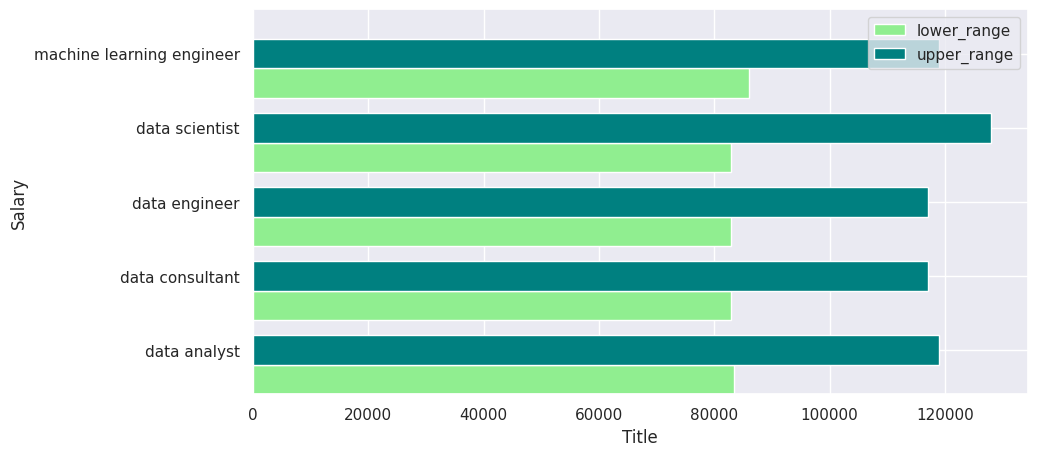

In [10]:
def convert_range_to_num(range_str, type):
  '''
  Helper function to convert range of salary to numeric form
  '''
  temp = range_str.split("-")
  if "K" in range_str:
    lower = int(temp[0][1:-1].strip())*1000
    upper = int(temp[1][1:temp[1].index("K")].strip())*1000
  else:
    lower = int(temp[0][1:].strip())*1000
    upper = int(temp[1][1:temp[1].index("P")].strip())*1000
  if type=='lower':
    return lower
  else:
    return upper


df["sal_lower_value"] = df["Salary Estimate"].apply(lambda x: convert_range_to_num(x, 'lower'))
df["sal_upper_value"] = df["Salary Estimate"].apply(lambda x: convert_range_to_num(x, 'upper'))
sal = []
for name, group in df.groupby('normalized_adj_classes',as_index=False):
  sal.append([name, group['sal_lower_value'].median(), group['sal_upper_value'].median()])

vizdf = pd.DataFrame(data=sal, columns=["title","lower_range","upper_range"])

plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()
index = list(vizdf.index)
sec_index = [ x+0.4 for x in index]

ax.barh(index, vizdf["lower_range"].values, height=0.4, color ='lightgreen', label='lower_range')
ax.barh(sec_index, vizdf["upper_range"].values+0.4, height=0.4, color ='teal', label='upper_range')
ax.set(yticks=sec_index, yticklabels=vizdf["title"].values, ylim=[2*0.4 - 1, len(vizdf)])
plt.legend()
plt.xlabel("Title")
plt.ylabel("Salary")
plt.show()

# Tokenizing the dataset

We will one-hot-encode each character of the text so as to get a vector representation which we can use as input to the RNN model.


* We consider only lowercase English characters(a-z) and space in our vocabulary so total 27 characters  
* We first create a mapping from character to index like 'c':2 which means in the one-hot vector set index 2 to 1 to represent 'c'
*  So 'abc' is one-hot-encoded as [[1,0,0,0,...],[0,1,0,0,0,...],[0,0,1,0,0,...]]



In [11]:
import re
import torch
mapping = {}

for index,i in enumerate(range(97, 123)):
  mapping[chr(i)]=index
mapping[' ']=26


def clean_text(text):
  text = text.lower()
  new_text = "".join([e for e in text if ord(e) in range(97,123) or ord(e)==32])
  return new_text

def convert_char_to_one_hot_encoded(ch):
  #a=97 z=122
  one_hot_enc = torch.zeros(1,26)
  one_hot_enc[0][ord(ch)%97] = 1
  return one_hot_enc

def convert_word_to_one_hot_encoded(word):
  one_hot_enc = torch.zeros(len(word), 1, 27)
  for index, char in enumerate(word):
    one_hot_enc[index][0][mapping[char]] = 1
  return one_hot_enc


In [12]:
from tqdm import tqdm

def encode_text(text, sequence_length):
      text = clean_text(text)
      text = text[0:sequence_length]
      text = convert_word_to_one_hot_encoded(text)
      return text

encoded_dataset = []
sequence_length = 100
for text in tqdm(df["Job Description"].values):
  encoded_dataset.append(encode_text(text, sequence_length))

#Creating a tensor for encoded texts  
X = torch.stack(encoded_dataset)

#Creating a mapping for labels to indices to use when converting labels to one-hot-encoded vectors
label_mapping={}
for index,label in enumerate(df["normalized_adj_classes"].unique()):
  label_mapping[label]=index


encoded_labels = []
for label in df["normalized_adj_classes"].values:
  one_hot_label=torch.zeros(1,len(df["normalized_adj_classes"].unique()))
  one_hot_label[0][label_mapping[label]]=1
  encoded_labels.append(one_hot_label)

Y = torch.stack(encoded_labels)
#Making train and validation splits -- 80% in train and 20% in validation
training_X = X[0:int(len(X)*0.8)]
training_Y = Y[0:int(len(Y)*0.8)] 
training_dataset = torch.utils.data.TensorDataset(training_X,training_Y)

validation_X = X[int(len(X)*0.8):]
validation_Y = Y[int(len(X)*0.8):]
validation_dataset = torch.utils.data.TensorDataset(validation_X, validation_Y)

100%|██████████| 1000/1000 [00:03<00:00, 328.96it/s]


## Model architecture

<p>RNN or Recurrent Neural Networks are a popular deep learning network architecture for processing sequential data. RNNs have been a popular choice for NLP applications for many years, most recently their popularity have given way to Transformer based architectures. The basic architecture and formulae for calculating hidden state and output value in RNN is as follows</p>

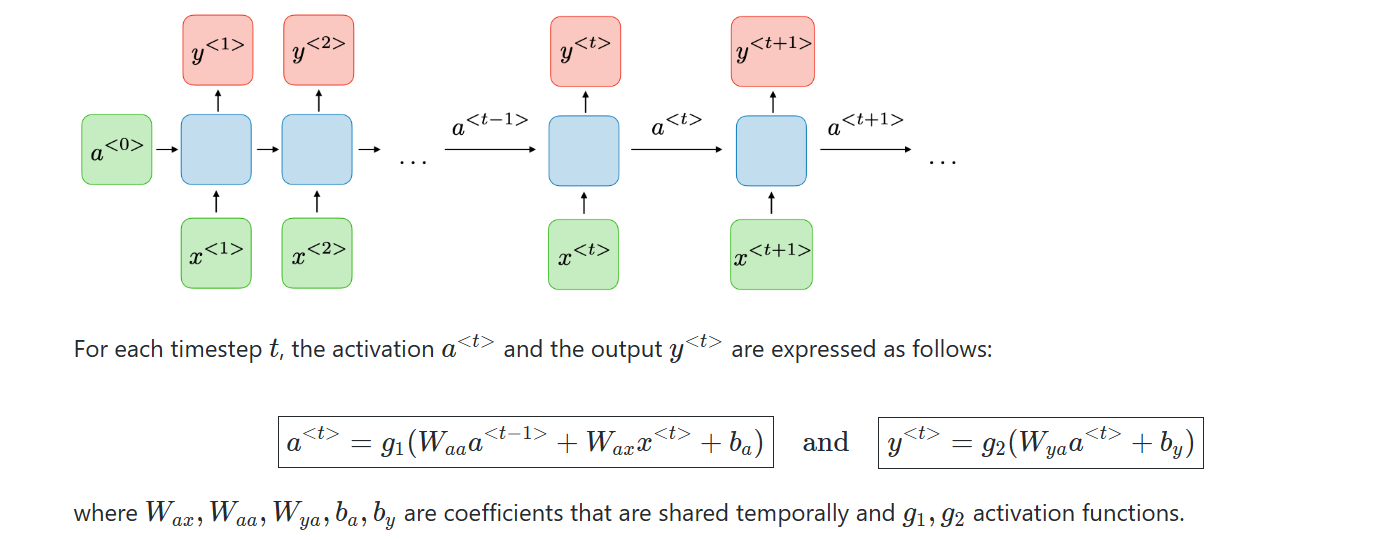







In [13]:
import torch
torch.manual_seed(0)
from tqdm import tqdm


class MyRNN(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.wax = torch.nn.Linear(input_size, hidden_size)
    self.waa = torch.nn.Linear(hidden_size, hidden_size)
    self.way = torch.nn.Linear(hidden_size, output_size)

    self.g1 = torch.nn.ReLU()
    self.g2 = torch.nn.Softmax()

  def forward(self, sample):
    hidden_state = torch.zeros(1, self.hidden_size)
    for each_char in sample:
      waa = self.waa(hidden_state)
      wax = self.wax(each_char)
      hidden_state = self.g1((waa+wax))
    way = self.way(hidden_state)
    return way

Here's how the RNN works
Let's say we give as input to the RNN a text sequence "abc" - after one-hot encoding it, this becomes [[1,0,0,...],[0,1,0,0...],[0,0,1,0,0...]]
- The RNN processes the text sequence sequentially, one character at a time
- Input size is size of the one-hot encoded vector ( or total number of characters in the vocabulary) which is 27
- Hidden size can be anything we want and it is the number of nodes in a hidden layer. Let's make it 3.
- The 1st character which is processed is "a" or [1,0,0,...] a tensor of size 27. This is multiplied with the weight matrix ( linear layer ) stored in self.wax which has a shape of (27, 3). Input has shape 27. Output is a tensor of size 3.
- In pytorch, torch.nn.Linear is defined as accepting input of shape ( * ,A) and provides an output of shape ( * ,B) by performing matrix multiplication and * can be any number of dimensions or None.
- For 1st character hidden state is a size 3 zero tensor which is also multipled by a different weight matrix stored in self.waa to output a tensor of size 3. This tensor and the tensor we got in previous step is added and activation applied - which now becomes the new hidden state. This new hidden state is used when we process "b". After all characters are processed, we multiply the last hidden state with a 3rd weight matrix of shape (3, num_classes) to get a tensor of shape num_classes which contain the raw logits. No need to apply softmax on this since cross_entropy function of torch.nn.functional will do that internally.
- Note that the same weights are used when processing "a","b" and "c" -  that is, self.wax is multiplied by the vector representation of "a", the same weights of self.wax are also used when processing "b" as well as "c". During training, between any 2 forward passes the weights will vary but during a given forward pass, the same weights will be used, self.wax is same for "a","b","c", self.waa is same for all the hidden states. This parameter sharing reduces model complexity as the total number of parameters to learn for the RNN is constant, irrespective of what is the sequence length. If an RNN has M learnable parameters for sequence length 100, then at sequence length 200, it still has M learnable parameters only, it does not need additional parameters as number of time steps increases, it only needs the 3 weight matrices which it will repeat ( share ) across the time steps

## Training and evaluation

In [14]:
import matplotlib.pyplot as plt
from torcheval.metrics.functional import multiclass_f1_score
import gc
gc.collect()

def plot_graphs(loss_value, title):
      plt.figure(figsize=(5,5))
      plt.plot(range(1, len(loss_value)+1), loss_value)
      plt.title(title)
      plt.show()

def validation_metrics(batch_out, labels, metrics_type="accuracy",num_classes=2):
  pred = torch.argmax(torch.nn.functional.softmax(batch_out), dim=-1)
  labels = torch.argmax(labels, dim=-1)
  if metrics_type=="accuracy":
    return sum(pred == labels)/len(pred)
  elif metrics_type=="f1 micro":
    return multiclass_f1_score(pred, labels, num_classes=num_classes, average="micro")
  elif metrics_type =="f1 macro":
    return multiclass_f1_score(pred, labels, num_classes=num_classes, average="macro")

def training_loop(**kwargs):
    model = kwargs["model"]
    dataloader = kwargs["train_dataloader"]
    val_dataloader = kwargs["validation_dataloader"]
    learning_rate = kwargs.get("lr",0.0000001)
    optimizer = kwargs.get("optimizer", torch.optim.RMSprop(model.parameters(), \
                                                            lr=learning_rate))
    epochs = kwargs.get("epochs",10)
    sched = kwargs.get("scheduler", \
                       torch.optim.lr_scheduler.OneCycleLR(optimizer,learning_rate, \
                                                           epochs=epochs, 
                                                steps_per_epoch=len(dataloader)))
    print("Starting training with these parameters - ", kwargs)
    final_loss_value = []
    final_val_loss_value = []
    final_val_metrics = []
    for i in tqdm(range(1,epochs+1)):
        model.train()
        loss_value = []
        for text, label in dataloader:
          batch_out = []
          for t in text:
            out = model(t)
            batch_out.append(out)
          batch_out = torch.vstack(batch_out)#Use vstack not stack, using stack the 
          #pred shape is 2,1,2 
          #but should be just 2,2
          #print(batch_out.shape, label.shape)
          label = label.squeeze(1)
          loss = torch.nn.functional.cross_entropy(batch_out, label)
          loss_value.append(loss)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          sched.step()
        epoch_loss = torch.stack(loss_value).mean().detach()
        print("Epoch number {} \t Train Loss {}".format(i, epoch_loss))
        final_loss_value.append(epoch_loss)

        #For validation
        each_batch_metrics = []
        loss_value = []
        model.eval()
        with torch.no_grad():
            for text, label in val_dataloader:
              batch_out = []
              for t in text:
                out = model(t)
                batch_out.append(out)
              batch_out = torch.vstack(batch_out)
              label = label.squeeze(1)
              loss = torch.nn.functional.cross_entropy(batch_out, label)
              loss_value.append(loss)
              each_batch_metrics.append(validation_metrics(batch_out, label,"f1 micro",\
                                                len(label_mapping.keys())))
              #each_batch_metrics.append(loss)
        final_val_metrics.append(torch.stack(each_batch_metrics).mean().detach())
        final_val_loss_value.append(torch.stack(loss_value).mean().detach())
              


    plot_graphs(final_loss_value, "Train Loss vs Epochs")
    plot_graphs(final_val_loss_value, "Validation Loss vs Epochs")
    plot_graphs(final_val_metrics, "Validation metric vs Epochs")
    return model

Starting training with these parameters -  {'model': MyRNN(
  (wax): Linear(in_features=27, out_features=3, bias=True)
  (waa): Linear(in_features=3, out_features=3, bias=True)
  (way): Linear(in_features=3, out_features=5, bias=True)
  (g1): ReLU()
  (g2): Softmax(dim=None)
), 'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7fc1540bd0c0>, 'validation_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7fc2032f9f00>, 'epochs': 10}


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch number 1 	 Train Loss 1.4231454133987427


<ipython-input-14-9cc5971d90af>:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(torch.nn.functional.softmax(batch_out), dim=-1)
 10%|█         | 1/10 [00:12<01:51, 12.41s/it]

Epoch number 2 	 Train Loss 1.4230324029922485


 20%|██        | 2/10 [00:24<01:38, 12.36s/it]

Epoch number 3 	 Train Loss 1.4228615760803223


 30%|███       | 3/10 [00:37<01:29, 12.76s/it]

Epoch number 4 	 Train Loss 1.422676682472229


 40%|████      | 4/10 [00:54<01:25, 14.25s/it]

Epoch number 5 	 Train Loss 1.4224953651428223


 50%|█████     | 5/10 [01:06<01:07, 13.56s/it]

Epoch number 6 	 Train Loss 1.422325611114502


 60%|██████    | 6/10 [01:19<00:52, 13.11s/it]

Epoch number 7 	 Train Loss 1.422176718711853


 70%|███████   | 7/10 [01:31<00:38, 12.87s/it]

Epoch number 8 	 Train Loss 1.4220609664916992


 80%|████████  | 8/10 [01:44<00:25, 12.88s/it]

Epoch number 9 	 Train Loss 1.4219908714294434


 90%|█████████ | 9/10 [01:56<00:12, 12.73s/it]

Epoch number 10 	 Train Loss 1.4219672679901123


100%|██████████| 10/10 [02:08<00:00, 12.90s/it]


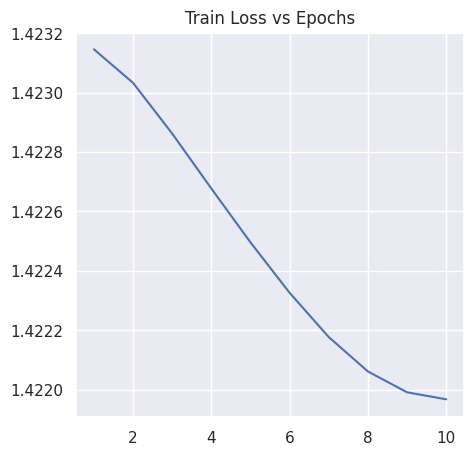

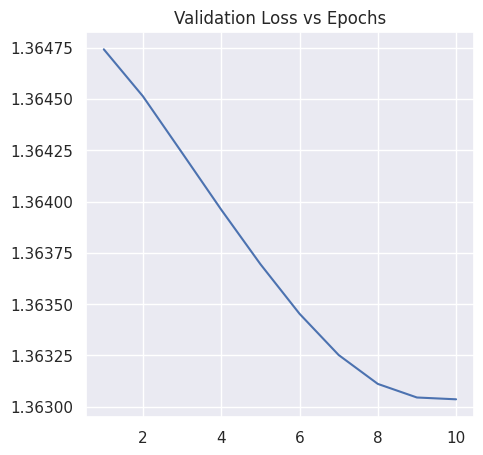

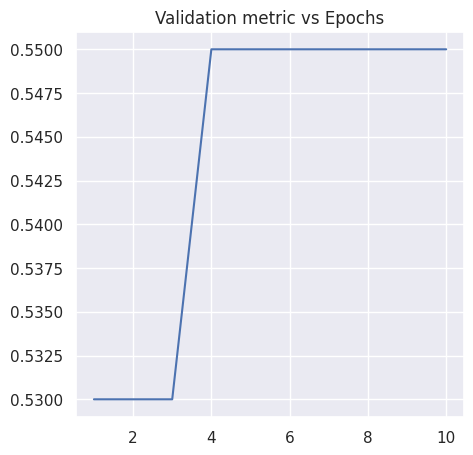

In [15]:
#Initialization and training
gc.collect()
model = MyRNN(27, 3, len(label_mapping.keys())) 
train_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=2)
val_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=2)
args = {
    "model":model,
    "train_dataloader":train_dataloader,
    "validation_dataloader":val_dataloader,
    "epochs":10
}
model = training_loop(**args)

## Results and discussion 

- Initally the model wasn't able to learn much and it kept fixating on the majority class ( mode collapse )
- Then by reducing the learning rate and batch size, the model started learning better and started producing better looking loss vs epochs graphs
- Optimal sequence length on this dataset and model is 100, other values causing much reduced performance on validation set
- We take micro f1 as evaluation criteria as we want to see model performance overall for all the samples and not for specific classes - to see performance for specific classes, weighted macro f1 is more suited. For now, overall model performance is sufficient to understand if the model architecture is okay and the hyperparameters used are meaningful or not.
- From the nature of the graphs for train and validation loss vs epochs, it looks like our training pipeline and model architecture is correctly defined  since the loss value is consistently decreasing for each epoch and we got a validation f1 score of 0.55. Given the small dataset size(total 1000 samples), sequence length of 100 characetrs, simple tokenization and model architecture, this performance value is not too bad. 

<h5>Ways to improve model performance</h5>

- Get a larger dataset to get more training samples
- Use word level tokenization in place of character level tokenization as one-hot encoded characters with 100 character sequence length is not enough to capture more complex relationships between job title and job description
- Use longer sequence length on larger dataset. However one drawback of RNN is that it does not work well for very long sequence length so optimal sequence length needs to be decided experimentally.
- Use improved architectures such as LSTM ( solves vanishing gradient problem in RNNs, helps to capture long range dependencies ) or GRUs ( simpler architecture than LSTM, trains faster) or fine-tune pre-trained Transformer based models like BERT

<h4>Let's take few samples from validation dataset and see how the model performs on them</h4>



In [23]:
valid = df[int(len(df)*0.8):].reset_index()

In [17]:
id_to_label = {value:key for key, value in label_mapping.items()}

In [27]:
def infer(job_description, truth_label):
    model.eval()
    with torch.no_grad():
          encoded = encode_text(job_description, 100)
          pred = model(encoded)
          pred = torch.argmax(pred, dim=-1).detach().numpy()
          print("Predicted = {} \t Truth = {}".format(id_to_label[pred[0]], truth_label))


In [36]:
sample = valid.loc[0]["Job Description"]
truth_label = valid.loc[0]["normalized_adj_classes"]
infer(sample, truth_label)
print("Text = {}".format(sample))

Predicted = data consultant 	 Truth = data consultant
Text = Employee Type:

Full time

Location:

MD Cambridge

Job Type:

Research and Development

Job Posting Title:

Food Scientist

Job Description:
Under limited supervision, works collaboratively in the execution of development from bench to production scale for new products, product improvements and cost savings projects.
Defines the formulation, nutritional and process parameters needed to develop a product which meets the project objective(s). Understands the impact of these parameters to overall project.
Applies sound scientific methods in all stages of development. Including planning and executing trials, analyzing data and defining solutions to achieve project goals.
Identifies opportunities for competitive market advantage
Provide judgement and experience to assure that an appropriate level of technical knowledge and discipline are being applied and utilized in business decisions
Partner and communicate effectively with cro

In [37]:
sample = valid.loc[10]["Job Description"]
truth_label = valid.loc[10]["normalized_adj_classes"]
infer(sample, truth_label)
print("Text = {}".format(sample))

Predicted = data scientist 	 Truth = data scientist
Text = Hi, Hope you are doing good. please find the below requirement and let me know if you are interested. Tittle Data Scientist with Python Location Chicago, IL Duration Long term Data engineering services required Build data products and processes alongside the core engineering and technology team Collaborate with senior data scientists to curate, wrangle, and prepare data for use in their advanced analytical models Integrate data from a variety of sources, assuring that they adhere to data quality and accessibility standards Modify and improve data engineering processes to handle ever larger, more complex, and more types of data sources and pipelines Use Hadoop architecture and HDFS commands to design and optimize data queries at scale Evaluate and experiment with novel data engineering tools and advises information technology leads and partners about new capabilities to determine optimal solutions for particular technical proble

In [38]:
sample = valid.loc[9]["Job Description"]
truth_label = valid.loc[9]["normalized_adj_classes"]
infer(sample, truth_label)
print("Text = {}".format(sample))

Predicted = data consultant 	 Truth = data scientist
Text = At Wish, our Data Science & Engineering team is comprised of Data Scientists, Data Analysts & Data Engineers who focus on centralizing corporate data in order to gain insights, knowledge and scalability, that empower a proactive and rigorous analysis of key business indicators. Our mission is to derive wisdom from data via the application of Data Science.

Wish has exciting opportunities for talented Data Scientists to form the foundation of our centralized data science team. Successful candidates will have extensive backgrounds in a quantitative fields and s track record of using data to drive the understanding, growth, and the success of a product. As a member of this team, you will be empowered and motivated to drive business impact through data.

As a Data Scientist at Wish, you will:
Apply statistics techniques to improve Wish’s experimentation platform and process.
Apply economics methodologies to understand and improve 

<h4>Conclusion</h4>

Good learning regarding RNNs and had fun playing around with a new dataset.
It was a nice weekend project :)